<a href="https://colab.research.google.com/github/asukakuwahara/Nassar_et_al_2016/blob/main/Nassar_2016_Norm%2C_Flex%2C_and_Demo_Rough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy import stats
import pandas as pd
from graphviz import Digraph
import pandas as pd
from scipy.ndimage import gaussian_filter1d

In [ ]:
field = np.arange(0,301,1)

# Prediction error

$\delta_t = X_t - B_t$

Trial outcomes and participant bucket placements determined the prediction error (and consequently, surprise magnitide). X_t is our outcome and B_t is our bucket placement.

In [ ]:
def prediction_error(X_t, B_t):
    return X_t - B_t

# Uncertainty

$$
\tau_{t+1} = \frac{\sigma_\mu^2}{\sigma_\mu^2 + \sigma_N^2}
$$


Where sig_mu is the variance of the predicted distribution over posisble helicopter locations and sig_N is the distribution over noise (possible bag distributions).

Sig_mu^2 is the variance on the predictive distribution over possible helicopter locations:

$$\sigma_{\mu}^2 = \Omega_t \sigma_N^2 + (1 - \Omega_t)\sigma_N^2 \tau_t + \Omega_t(1 - \Omega_t)\delta_t(1 - \tau_t)$$

In [ ]:
def predictive_variance(Omega_t, sigma_N, tau_t, delta_t):
    sigma_mu_sq = (
        Omega_t * (sigma_N ** 2)
        + (1 - Omega_t) * (sigma_N ** 2) * tau_t
        + Omega_t * (1 - Omega_t) * delta_t * (1 - tau_t))
    return sigma_mu_sq

In [ ]:
def relative_uncertainty(sig_mu,sig_N):
    return sig_mu**2 / (sig_mu**2 + sig_N**2)

# Change Point Probability

$$
\Omega_{t+1} = \frac{H / 300}{H / 300 + \mathcal{N}^\sim \left( \delta_{t+1} \mid 0, \frac{\sigma_N^2}{1 - \tau_{t+1}} \right) (1 - H)}
$$


$$p(cp)=H$$

In [ ]:
def prior_CP(H):
    return H

$$
{\mathcal{N}^\sim \left( \delta_{t+1} \mid 0, \frac{\sigma_N^2}{1 - \tau_{t+1}} \right)}
$$

In [ ]:
def probability_normal(delta_t1, sigma_N, tau_t1):
    sigma = np.sqrt(sigma_N**2 / (1 - tau_t1))
    return stats.norm.pdf(delta_t1, loc=0, scale=sigma)

$$
\Omega_{t+1} = \frac{H / 300}{H / 300 + \mathcal{N}^\sim \left( \delta_{t+1} \mid 0, \frac{\sigma_N^2}{1 - \tau_{t+1}} \right) (1 - H)}
$$


In [ ]:
def probability_change_point_new(H, delta_t1, sigma_N, tau_t1):
    num = prior_CP(H) / 300.0
    den = num + probability_normal(delta_t1, sigma_N, tau_t1)*(1 - H)
    return num / den

The recursive computation serves as a normative model designed to dynamically adjust learning rates on each trial, optimizing inference in a dynamic environment.

1. **Calculate Predictive Variance (`σ_mu^2`)**  
   In other words, we calculate the raw estimation uncertainty about the location of the helicopter based on the previous trial variable values of CPP, relative uncertainty, and prediction error (surprise).
  2. **Compute Relative Uncertainty (`τ_{t+1}`)**  
   `σ_mu^2` is then used to calculate relative uncertainty, which now takes into account the uncertainty that is inherent to the environment (the ground-truch environmental noise).
   3. **Calibrate Change-Point Probability (`Ω_{t+1}`)**  
   CPP is calculated using our relative uncertainty, and ground-truth environmental noise, and prediction error. The value of CPP is highly contingent on the level of surprise. The larger the surprise, the larger the (subjective) measure of change-point probability is.

These subjective measures are used to update the learning rate.

### Learning rate
$α_t = Ω_t+τ_t*(1-Ω)$

In [ ]:
def learning_rate(omega_t1, tau_t1):
    return omega_t1 + (1 - omega_t1) * tau_t1

## Estimated Mean (Delta Rule)

$B_{t+1} = B_t + α_t * δ_t$

In [ ]:
def update_belief(B_t, alpha_t1, delta_t):
    return B_t + alpha_t1 * delta_t

## Full Model

In [ ]:
def run_nassar_model(X, H=0.1, sigma_N=10, B0=None):
    """
    X: sequence of outcomes (e.g. helicopter positions)
    H: hazard rate (prior change-point probability)
    sigma_N: environmental noise
    B0: initial belief (defaults to first observation)
    """

    n_trials = len(X)
    field_length = n_trials  # used for likelihood_CP()

    # Initialize arrays
    B = np.zeros(n_trials)
    Omega = np.zeros(n_trials)
    tau = np.zeros(n_trials)
    alpha = np.zeros(n_trials)
    delta = np.zeros(n_trials)

    # Initialize values
    if B0 is None:
        B[0] = X[0]
    else:
        B[0] = B0

    tau[0] = 0.1  # initial relative uncertainty

    for t in range(1, n_trials):
        delta[t] = prediction_error(X[t], B[t - 1])
        Omega[t] = probability_change_point_new(H, delta[t], sigma_N, tau[t - 1], field_length)
        sig_mu_sq = predictive_variance(Omega[t], sigma_N, tau[t - 1], delta[t])
        tau[t] = relative_uncertainty(np.sqrt(sig_mu_sq), sigma_N)
        alpha[t] = learning_rate(Omega[t], tau[t])
        B[t] = update_belief(B[t - 1], alpha[t], delta[t])

    return {
        "Belief": B,
        "CPP": Omega,
        "RelUncertainty": tau,
        "LearningRate": alpha,
        "PredictionError": delta
    }

# Let's all work with the same deterministic environment.
Please don't change the seed -- we'll need to compare answers later on in the tutorial!

In [ ]:
def generate_environment(n_trials=400, H=0.1, sigma_low=10, sigma_high=25):
    """
    Generate helicopter (true) and bag (observed) positions for 400 trials:
    - First 200 trials: low noise
    - Last 200 trials: high noise
    Hazard rate H is fixed for all trials.
    Range of positions: 0-300
    """
    np.random.seed(42)  # reproducibility

    block_length = n_trials // 2
    sigma_sequence = np.concatenate([
        np.full(block_length, sigma_low),
        np.full(block_length, sigma_high)
    ])

    mu = np.zeros(n_trials)  # true helicopter position
    X = np.zeros(n_trials)   # observed bag drops

    # Initialize helicopter randomly
    mu[0] = np.random.uniform(0, 300)
    X[0] = np.random.normal(mu[0], sigma_sequence[0])

    # Generate trials
    for t in range(1, n_trials):
        # Change-point decision
        if np.random.rand() < H:
            mu[t] = np.random.uniform(0, 300)
        else:
            mu[t] = mu[t - 1]

        # Bag drop with current noise
        X[t] = np.random.normal(mu[t], sigma_sequence[t])

    return mu, X, sigma_sequence

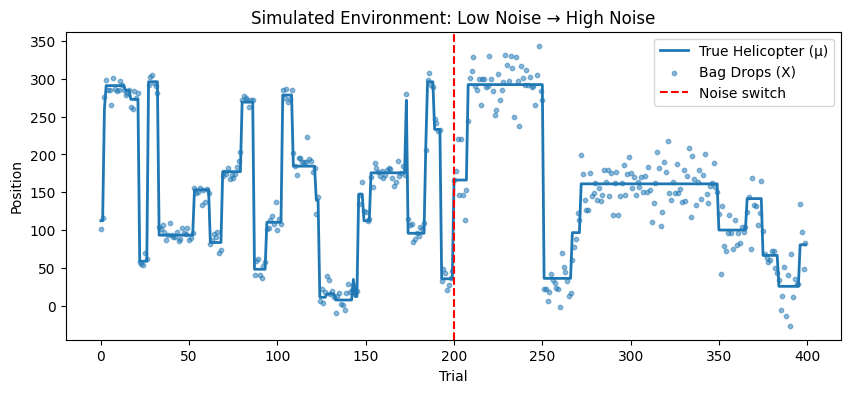

In [ ]:
mu, X, sigma_seq = generate_environment()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(mu, label='True Helicopter (μ)', linewidth=2)
plt.scatter(range(len(X)), X, s=10, alpha=0.5, label='Bag Drops (X)')
plt.axvline(200, color='red', linestyle='--', label='Noise switch')
plt.title('Simulated Environment: Low Noise → High Noise')
plt.xlabel('Trial')
plt.ylabel('Position')
plt.legend()
plt.show()

# Let's Run Our Normative Model on our Deterministic Environment

In [ ]:
def run_normative_model_df(X, sigma_sequence, H=0.1):
    """
    Runs the normative model and returns a DataFrame:
    Each row = trial, columns = Belief, CPP, RelUncertainty, LearningRate, PredictionError
    """
    n_trials = len(X)

    # Make 'field' available for likelihood_CP
    global field
    field = np.arange(n_trials)

    # Initialize arrays
    B = np.zeros(n_trials)
    Omega = np.zeros(n_trials)
    tau = np.zeros(n_trials)
    alpha = np.zeros(n_trials)
    delta = np.zeros(n_trials)

    # First trial
    B[0] = X[0]
    tau[0] = 0.1  # initial relative uncertainty

    for t in range(1, n_trials):
        delta[t] = prediction_error(X[t], B[t-1])
        Omega[t] = probability_change_point_new(H, delta[t], sigma_sequence[t], tau[t-1])
        sig_mu_sq = predictive_variance(Omega[t], sigma_sequence[t], tau[t-1], delta[t])
        tau[t] = relative_uncertainty(np.sqrt(sig_mu_sq), sigma_sequence[t])
        alpha[t] = learning_rate(Omega[t], tau[t])
        B[t] = update_belief(B[t-1], alpha[t], delta[t])

        # Clamp belief to 0-300
        B[t] = np.clip(B[t], 0, 300)

    # Create tidy DataFrame
    df = pd.DataFrame({
        "Trial": np.arange(1, n_trials + 1),
        "TruePosition": mu,        # global variable from environment
        "BagDrop": X,
        "Belief": B,
        "CPP": Omega,
        "RelUncertainty": tau,
        "LearningRate": alpha,
        "PredictionError": delta
    })

    return df

In [ ]:
normative_model = run_normative_model_df(X, sigma_seq, H=0.1)
display(normative_model)

,Trial,TruePosition,BagDrop,Belief,CPP,RelUncertainty,LearningRate,PredictionError
0,1,112.362036,101.243234,101.243234,0.000000,0.100000,0.000000,0.000000
1,2,112.362036,115.551058,103.133889,0.023996,0.110804,0.132141,14.307823
2,3,259.852844,275.644972,275.644972,1.000000,0.500000,1.000000,172.511083
3,4,290.972956,298.647303,284.306442,0.046970,0.345821,0.376548,23.002331
4,5,290.972956,285.164174,284.537588,0.011375,0.261079,0.269485,0.857732
...,...,...,...,...,...,...,...,...
395,396,25.652559,29.410103,29.395196,0.025016,0.168177,0.188986,0.018380
396,397,80.603208,134.484196,133.177747,0.975349,0.495677,0.987568,105.089000
397,398,80.603208,97.409640,119.713085,0.051919,0.342296,0.376443,-35.768107
398,399,80.603208,48.392023,81.532389,0.293746,0.342072,0.535335,-71.321062


# Normative Model (Optimal Behaviour in Response to our Determinisitc Environment)

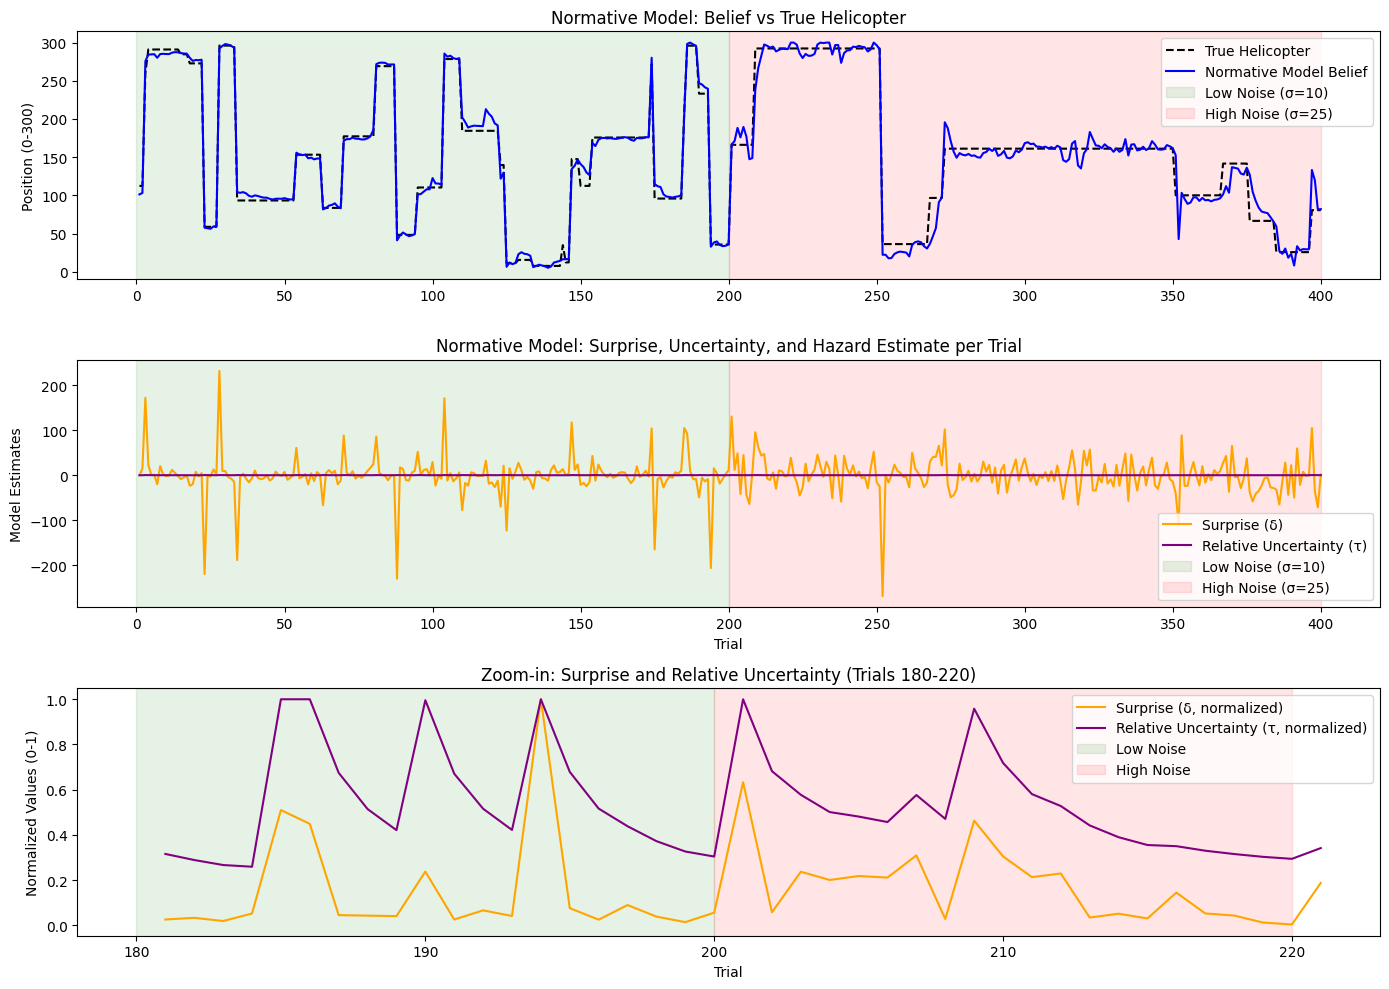

In [ ]:
plt.figure(figsize=(14,10))

# Plot 1: Trial vs Screen Position
plt.subplot(3,1,1)
plt.plot(normative_model['Trial'], normative_model['TruePosition'], 'k--', label='True Helicopter')
plt.plot(normative_model['Trial'], normative_model['Belief'], 'b-', label='Normative Model Belief')
plt.axvspan(0, 200, color='green', alpha=0.1, label='Low Noise (σ=10)')
plt.axvspan(200, 400, color='red', alpha=0.1, label='High Noise (σ=25)')
plt.ylabel("Position (0-300)")
plt.title("Normative Model: Belief vs True Helicopter")
plt.legend()

# Trial vs Model Estimates (Surprise, Uncertainty)
plt.subplot(3,1,2)
plt.plot(normative_model['Trial'], normative_model['PredictionError'], color='orange', label='Surprise (δ)')
plt.plot(normative_model['Trial'], normative_model['RelUncertainty'], color='purple', label='Relative Uncertainty (τ)')
plt.axvspan(0, 200, color='green', alpha=0.1, label='Low Noise (σ=10)')
plt.axvspan(200, 400, color='red', alpha=0.1, label='High Noise (σ=25)')
plt.ylabel("Model Estimates")
plt.xlabel("Trial")
plt.title("Normative Model: Surprise, Uncertainty, and Hazard Estimate per Trial")
plt.legend()

# Zoom-in
zoom_start, zoom_end = 180, 220
trials_zoom = normative_model['Trial'][zoom_start:zoom_end+1]

# Normalize for visual clarity
pred_error_zoom = np.abs(normative_model['PredictionError'][zoom_start:zoom_end+1])
pred_error_norm = pred_error_zoom / np.max(pred_error_zoom)
rel_unc_zoom = normative_model['RelUncertainty'][zoom_start:zoom_end+1]
rel_unc_norm = rel_unc_zoom / np.max(rel_unc_zoom)

plt.subplot(3,1,3)
plt.plot(trials_zoom, pred_error_norm, color='orange', label='Surprise (δ, normalized)')
plt.plot(trials_zoom, rel_unc_norm, color='purple', label='Relative Uncertainty (τ, normalized)')
plt.axvspan(180, 200, color='green', alpha=0.1, label='Low Noise')
plt.axvspan(200, 220, color='red', alpha=0.1, label='High Noise')
plt.ylabel("Normalized Values (0-1)")
plt.xlabel("Trial")
plt.title("Zoom-in: Surprise and Relative Uncertainty (Trials 180-220)")
plt.legend()

plt.tight_layout()
plt.show()

# Base Flexible Model

In [ ]:
def run_flexible_model(X, sigma_sequence, fixed_uncertainty_scale=None, fixed_surprise_power=None, fixed_hazard_rate=None):
    # Set defaults if None
    H = 0.1 if fixed_hazard_rate is None else fixed_hazard_rate
    uncertainty_scale = 1.0 if fixed_uncertainty_scale is None else fixed_uncertainty_scale
    surprise_power = 1.0 if fixed_surprise_power is None else fixed_surprise_power

    n_trials = len(X)
    global field
    field = np.arange(n_trials)

    # Initialize arrays
    B = np.zeros(n_trials)
    Omega = np.zeros(n_trials)
    tau = np.zeros(n_trials)
    alpha = np.zeros(n_trials)
    delta = np.zeros(n_trials)

    # First trial
    B[0] = X[0]
    tau[0] = 0.1

    for t in range(1, n_trials):
        delta[t] = prediction_error(X[t], B[t-1])

        # Apply surprise_power to likelihood before computing CPP
        likelihood_powered = (likelihood_CP()) ** surprise_power
        num = likelihood_powered * prior_CP(H)
        den = num + probability_normal(delta[t], sigma_sequence[t], tau[t-1])*(1 - H)
        Omega[t] = num / den

        sig_mu_sq = predictive_variance(Omega[t], sigma_sequence[t], tau[t-1], delta[t])
        sig_mu_sq /= uncertainty_scale

        tau[t] = relative_uncertainty(np.sqrt(sig_mu_sq), sigma_sequence[t])
        alpha[t] = learning_rate(Omega[t], tau[t])
        B[t] = update_belief(B[t-1], alpha[t], delta[t])
        B[t] = np.clip(B[t], 0, 300)

    df = pd.DataFrame({
        "Trial": np.arange(1, n_trials+1),
        "TruePosition": mu,
        "BagDrop": X,
        "Belief": B,
        "CPP": Omega,
        "RelUncertainty": tau,
        "LearningRate": alpha,
        "PredictionError": delta
    })

    return df

In [ ]:
def run_flexible_model(X, sigma_sequence, fixed_uncertainty_scale=None, fixed_surprise_power=None, fixed_hazard_rate=None):
    # Set defaults if None
    H = 0.1 if fixed_hazard_rate is None else fixed_hazard_rate
    uncertainty_scale = 1.0 if fixed_uncertainty_scale is None else fixed_uncertainty_scale
    surprise_power = 1.0 if fixed_surprise_power is None else fixed_surprise_power

    n_trials = len(X)
    global field
    field = np.arange(n_trials)

    # Initialize arrays
    B = np.zeros(n_trials)
    Omega = np.zeros(n_trials)
    tau = np.zeros(n_trials)
    alpha = np.zeros(n_trials)
    delta = np.zeros(n_trials)

    # First trial
    B[0] = X[0]
    tau[0] = 0.1

    for t in range(1, n_trials):
        delta[t] = prediction_error(X[t], B[t-1])

        # Compute powered normal likelihood instead of powering likelihood_CP
        normal_likelihood = probability_normal(delta[t], sigma_sequence[t], tau[t-1]) ** surprise_power

        num = likelihood_CP() * prior_CP(H)
        den = num + normal_likelihood * (1 - H)
        Omega[t] = num / den

        sig_mu_sq = predictive_variance(Omega[t], sigma_sequence[t], tau[t-1], delta[t])
        sig_mu_sq /= uncertainty_scale

        tau[t] = relative_uncertainty(np.sqrt(sig_mu_sq), sigma_sequence[t])
        alpha[t] = learning_rate(Omega[t], tau[t])
        B[t] = update_belief(B[t-1], alpha[t], delta[t])
        B[t] = np.clip(B[t], 0, 300)

    df = pd.DataFrame({
        "Trial": np.arange(1, n_trials + 1),
        "TruePosition": mu,
        "BagDrop": X,
        "Belief": B,
        "CPP": Omega,
        "RelUncertainty": tau,
        "LearningRate": alpha,
        "PredictionError": delta
    })

    return df


# Flexible No. 1: Uncertainty Underestimators

This model artificially reduces estimated uncertainty on every trial by dividing the predictive variance (σ_μ²) by a constant (fixed_uncertainty_scale) each trial.

For the simulation figures, Nassar et al. used 10.

You may choose to use a different constant.

In [ ]:
flex_model_uncertainty = run_flexible_model(X, sigma_seq, fixed_uncertainty_scale=10)
display(flex_model_uncertainty)

,Trial,TruePosition,BagDrop,Belief,CPP,RelUncertainty,LearningRate,PredictionError
0,1,112.362036,101.243234,101.243234,0.000000,0.100000,0.000000,0.000000
1,2,112.362036,115.551058,101.666927,0.018105,0.011719,0.029613,14.307823
2,3,259.852844,275.644972,275.644972,1.000000,0.090909,1.000000,173.978045
3,4,290.972956,298.647303,277.729471,0.074849,0.017048,0.090621,23.002331
4,5,290.972956,285.164174,277.816963,0.009131,0.002661,0.011768,7.434703
...,...,...,...,...,...,...,...,...
395,396,25.652559,29.410103,23.137990,0.017685,0.001979,0.019629,6.397693
396,397,80.603208,134.484196,134.193129,0.997125,0.090714,0.997386,111.346206
397,398,80.603208,97.409640,132.027700,0.046571,0.012900,0.058870,-36.783489
398,399,80.603208,48.392023,62.763065,0.814478,0.073809,0.828171,-83.635677


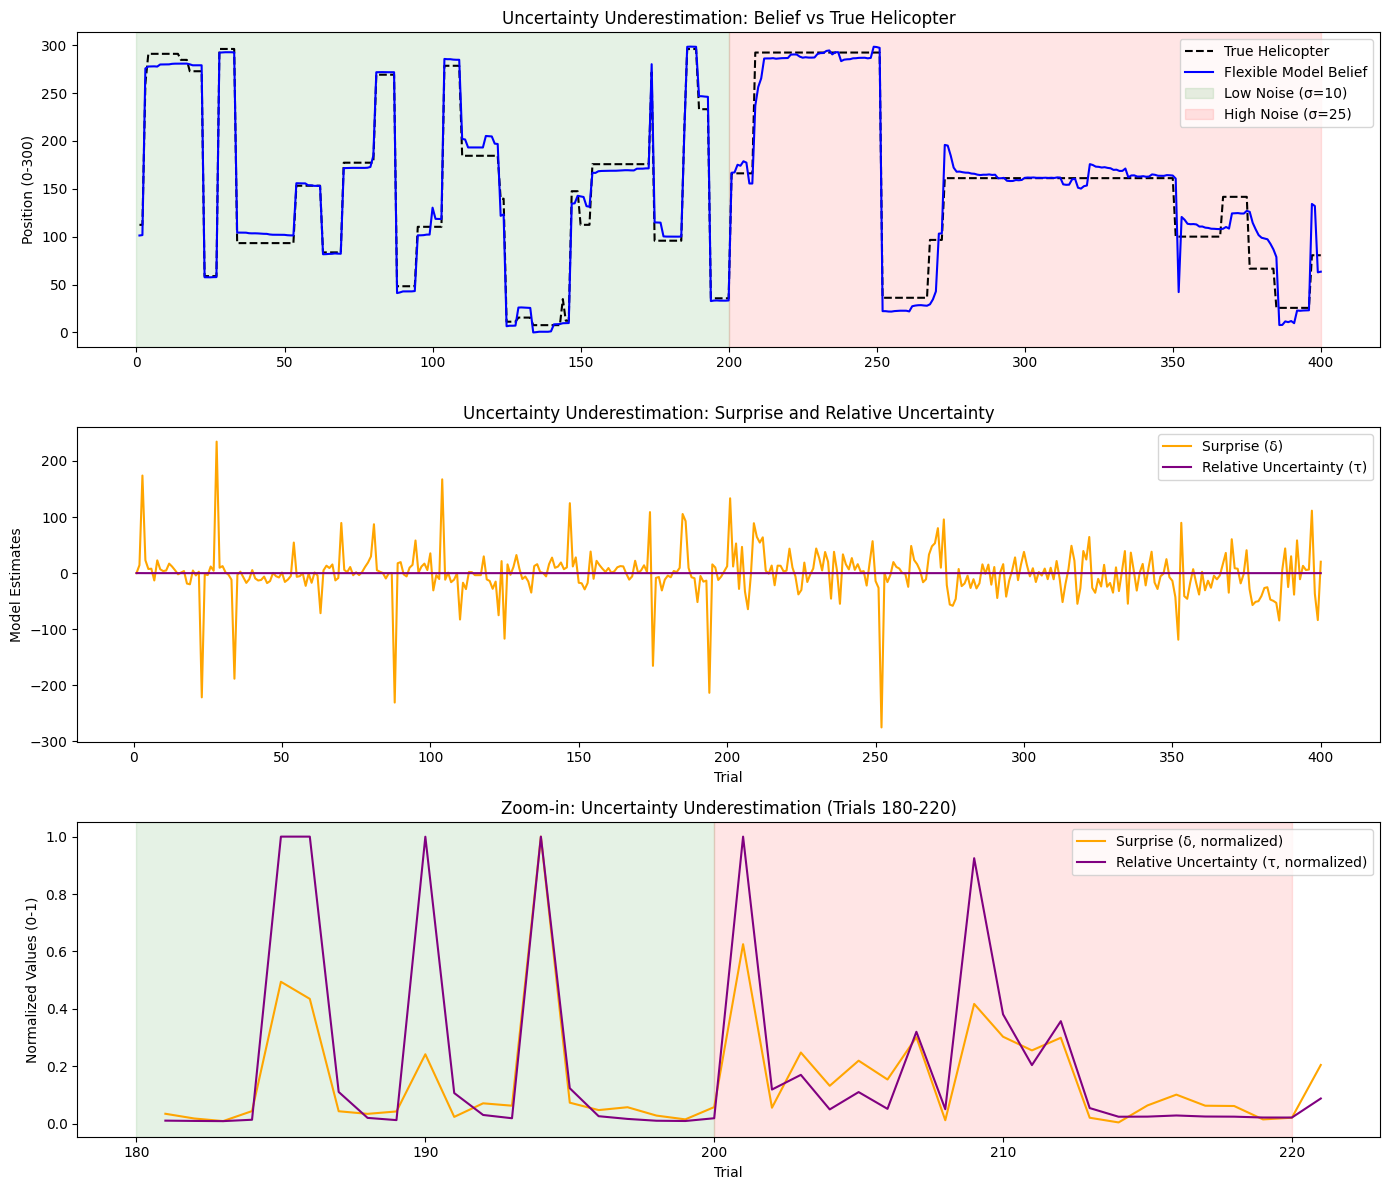

In [ ]:
plt.figure(figsize=(14,12))

# Top plot: Belief vs True Helicopter
plt.subplot(3,1,1)
plt.plot(flex_model_uncertainty['Trial'], flex_model_uncertainty['TruePosition'], 'k--', label='True Helicopter')
plt.plot(flex_model_uncertainty['Trial'], flex_model_uncertainty['Belief'], 'b-', label='Flexible Model Belief')
plt.axvspan(0, 200, color='green', alpha=0.1, label='Low Noise (σ=10)')
plt.axvspan(200, 400, color='red', alpha=0.1, label='High Noise (σ=25)')
plt.ylabel("Position (0-300)")
plt.title("Uncertainty Underestimation: Belief vs True Helicopter")
plt.legend()

# Middle plot: Prediction error & relative uncertainty
plt.subplot(3,1,2)
plt.plot(flex_model_uncertainty['Trial'], flex_model_uncertainty['PredictionError'], color='orange', label='Surprise (δ)')
plt.plot(flex_model_uncertainty['Trial'], flex_model_uncertainty['RelUncertainty'], color='purple', label='Relative Uncertainty (τ)')
plt.ylabel("Model Estimates")
plt.xlabel("Trial")
plt.title("Uncertainty Underestimation: Surprise and Relative Uncertainty")
plt.legend()

# Bottom plot: Zoom-in (trials 180-220)
zoom_start, zoom_end = 180, 220
plt.subplot(3,1,3)
# Normalize for visibility
pred_zoom = np.abs(flex_model_uncertainty['PredictionError'][zoom_start:zoom_end+1])
pred_zoom_norm = pred_zoom / np.max(pred_zoom)
tau_zoom = flex_model_uncertainty['RelUncertainty'][zoom_start:zoom_end+1]
tau_zoom_norm = tau_zoom / np.max(tau_zoom)
trials_zoom = flex_model_uncertainty['Trial'][zoom_start:zoom_end+1]

plt.plot(trials_zoom, pred_zoom_norm, color='orange', label='Surprise (δ, normalized)')
plt.plot(trials_zoom, tau_zoom_norm, color='purple', label='Relative Uncertainty (τ, normalized)')
plt.axvspan(180, 200, color='green', alpha=0.1)
plt.axvspan(200, 220, color='red', alpha=0.1)
plt.ylabel("Normalized Values (0-1)")
plt.xlabel("Trial")
plt.title("Zoom-in: Uncertainty Underestimation (Trials 180-220)")
plt.legend()

plt.tight_layout()
plt.show()

# Flexible No. 2: Surprise Insensitivity

In [ ]:
flex_model_surprise = run_flexible_model(X, sigma_seq, fixed_surprise_power=0.2)
display(flex_model_surprise)

,Trial,TruePosition,BagDrop,Belief,CPP,RelUncertainty,LearningRate,PredictionError
0,1,112.362036,101.243234,101.243234,0.000000,0.100000,0.000000,0.000000
1,2,112.362036,115.551058,102.560107,0.000642,0.091455,0.092039,14.307823
2,3,259.852844,275.644972,275.644972,1.000000,0.500000,1.000000,173.084865
3,4,290.972956,298.647303,283.328372,0.000738,0.333535,0.334027,23.002331
4,5,290.972956,285.164174,283.788677,0.000552,0.250324,0.250738,1.835802
...,...,...,...,...,...,...,...,...
395,396,25.652559,29.410103,80.333921,0.000981,0.036605,0.037550,-52.910587
396,397,80.603208,134.484196,82.351099,0.001001,0.036286,0.037251,54.150275
397,398,80.603208,97.409640,82.897102,0.000660,0.035622,0.036259,15.058541
398,399,80.603208,48.392023,81.662303,0.000766,0.035047,0.035786,-34.505078


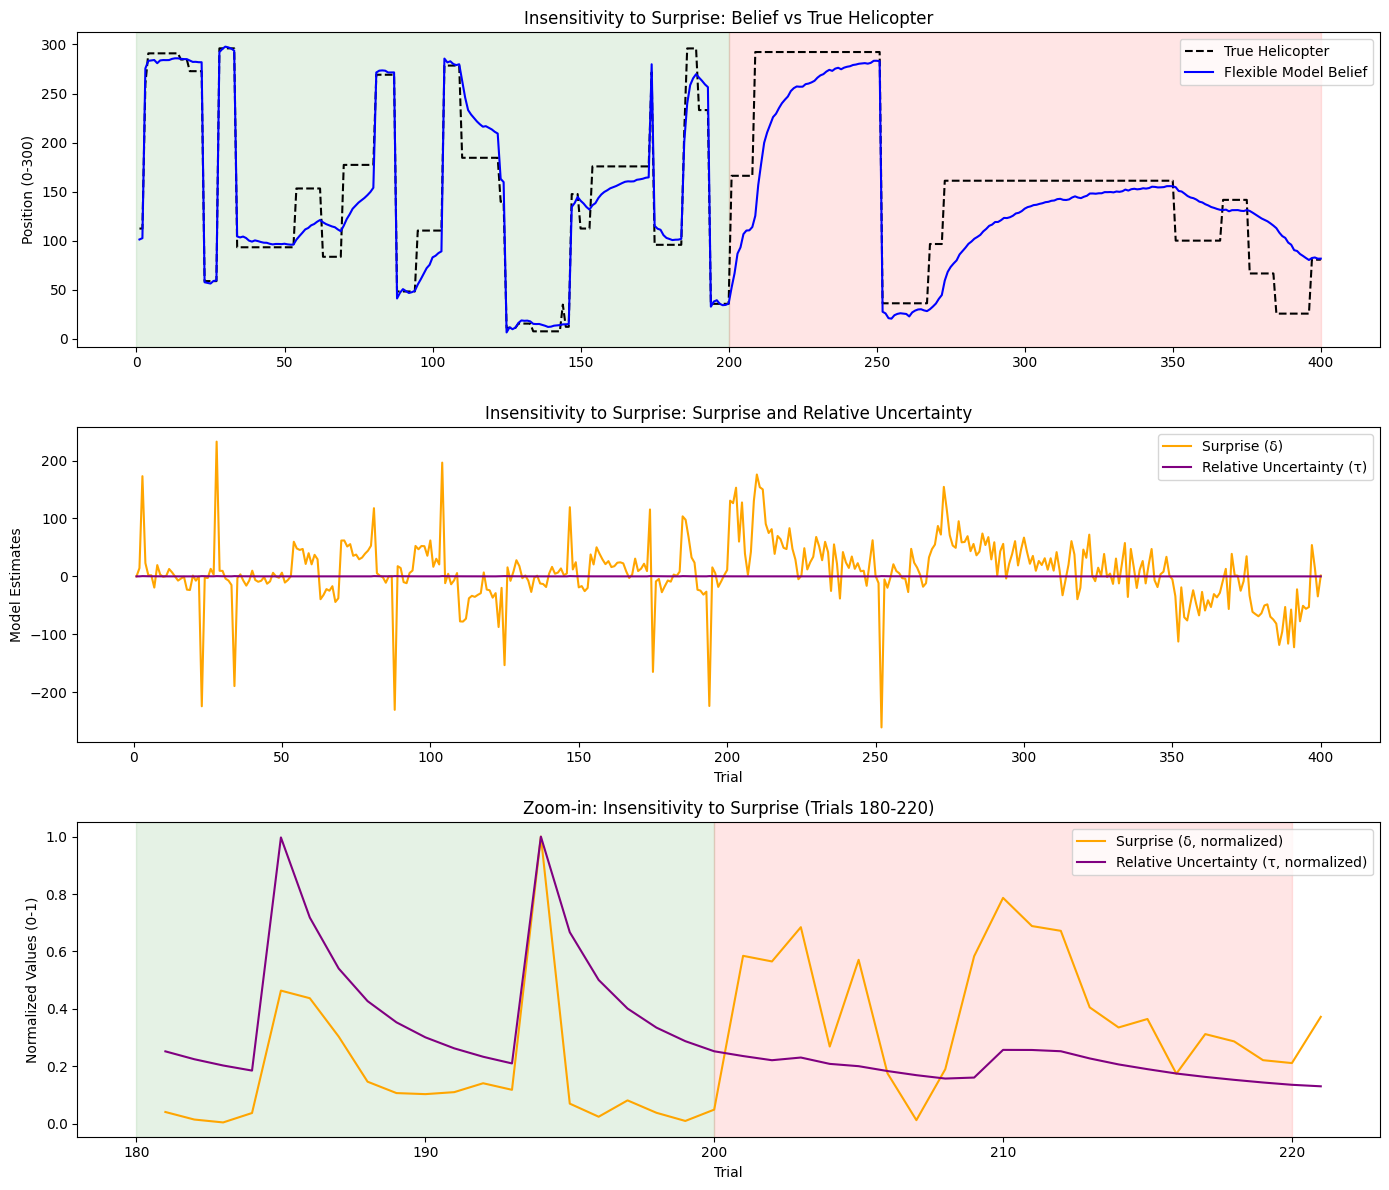

In [ ]:
plt.figure(figsize=(14,12))

# Top plot: Belief vs True Helicopter
plt.subplot(3,1,1)
plt.plot(flex_model_surprise['Trial'], flex_model_surprise['TruePosition'], 'k--', label='True Helicopter')
plt.plot(flex_model_surprise['Trial'], flex_model_surprise['Belief'], 'b-', label='Flexible Model Belief')
plt.axvspan(0, 200, color='green', alpha=0.1)
plt.axvspan(200, 400, color='red', alpha=0.1)
plt.ylabel("Position (0-300)")
plt.title("Insensitivity to Surprise: Belief vs True Helicopter")
plt.legend()

# Middle plot: Prediction error & relative uncertainty
plt.subplot(3,1,2)
plt.plot(flex_model_surprise['Trial'], flex_model_surprise['PredictionError'], color='orange', label='Surprise (δ)')
plt.plot(flex_model_surprise['Trial'], flex_model_surprise['RelUncertainty'], color='purple', label='Relative Uncertainty (τ)')
plt.ylabel("Model Estimates")
plt.xlabel("Trial")
plt.title("Insensitivity to Surprise: Surprise and Relative Uncertainty")
plt.legend()

# Bottom plot: Zoom-in
zoom_start, zoom_end = 180, 220
plt.subplot(3,1,3)
pred_zoom = np.abs(flex_model_surprise['PredictionError'][zoom_start:zoom_end+1])
pred_zoom_norm = pred_zoom / np.max(pred_zoom)
tau_zoom = flex_model_surprise['RelUncertainty'][zoom_start:zoom_end+1]
tau_zoom_norm = tau_zoom / np.max(tau_zoom)
trials_zoom = flex_model_surprise['Trial'][zoom_start:zoom_end+1]

plt.plot(trials_zoom, pred_zoom_norm, color='orange', label='Surprise (δ, normalized)')
plt.plot(trials_zoom, tau_zoom_norm, color='purple', label='Relative Uncertainty (τ, normalized)')
plt.axvspan(180, 200, color='green', alpha=0.1)
plt.axvspan(200, 220, color='red', alpha=0.1)
plt.ylabel("Normalized Values (0-1)")
plt.xlabel("Trial")
plt.title("Zoom-in: Insensitivity to Surprise (Trials 180-220)")
plt.legend()

plt.tight_layout()
plt.show()

# Flexible No. 3: Low Hazard Rate Environment

In [ ]:
flex_model_hazard = run_flexible_model(X, sigma_seq, fixed_hazard_rate=0.001)
display(flex_model_hazard)

,Trial,TruePosition,BagDrop,Belief,CPP,RelUncertainty,LearningRate,PredictionError
0,1,112.362036,101.243234,101.243234,0.000000,0.100000,0.000000,0.000000
1,2,112.362036,115.551058,102.548126,0.000166,0.091050,0.091201,14.307823
2,3,259.852844,275.644972,275.644972,1.000000,0.500000,1.000000,173.096846
3,4,290.972956,298.647303,283.319612,0.000333,0.333424,0.333646,23.002331
4,5,290.972956,285.164174,283.781009,0.000078,0.250081,0.250139,1.844562
...,...,...,...,...,...,...,...,...
395,396,25.652559,29.410103,37.497865,0.000172,0.065014,0.065175,-8.651629
396,397,80.603208,134.484196,67.885784,0.155651,0.186736,0.313322,96.986332
397,398,80.603208,97.409640,72.544544,0.000307,0.157538,0.157796,29.523856
398,399,80.603208,48.392023,69.248469,0.000253,0.136251,0.136469,-24.152521


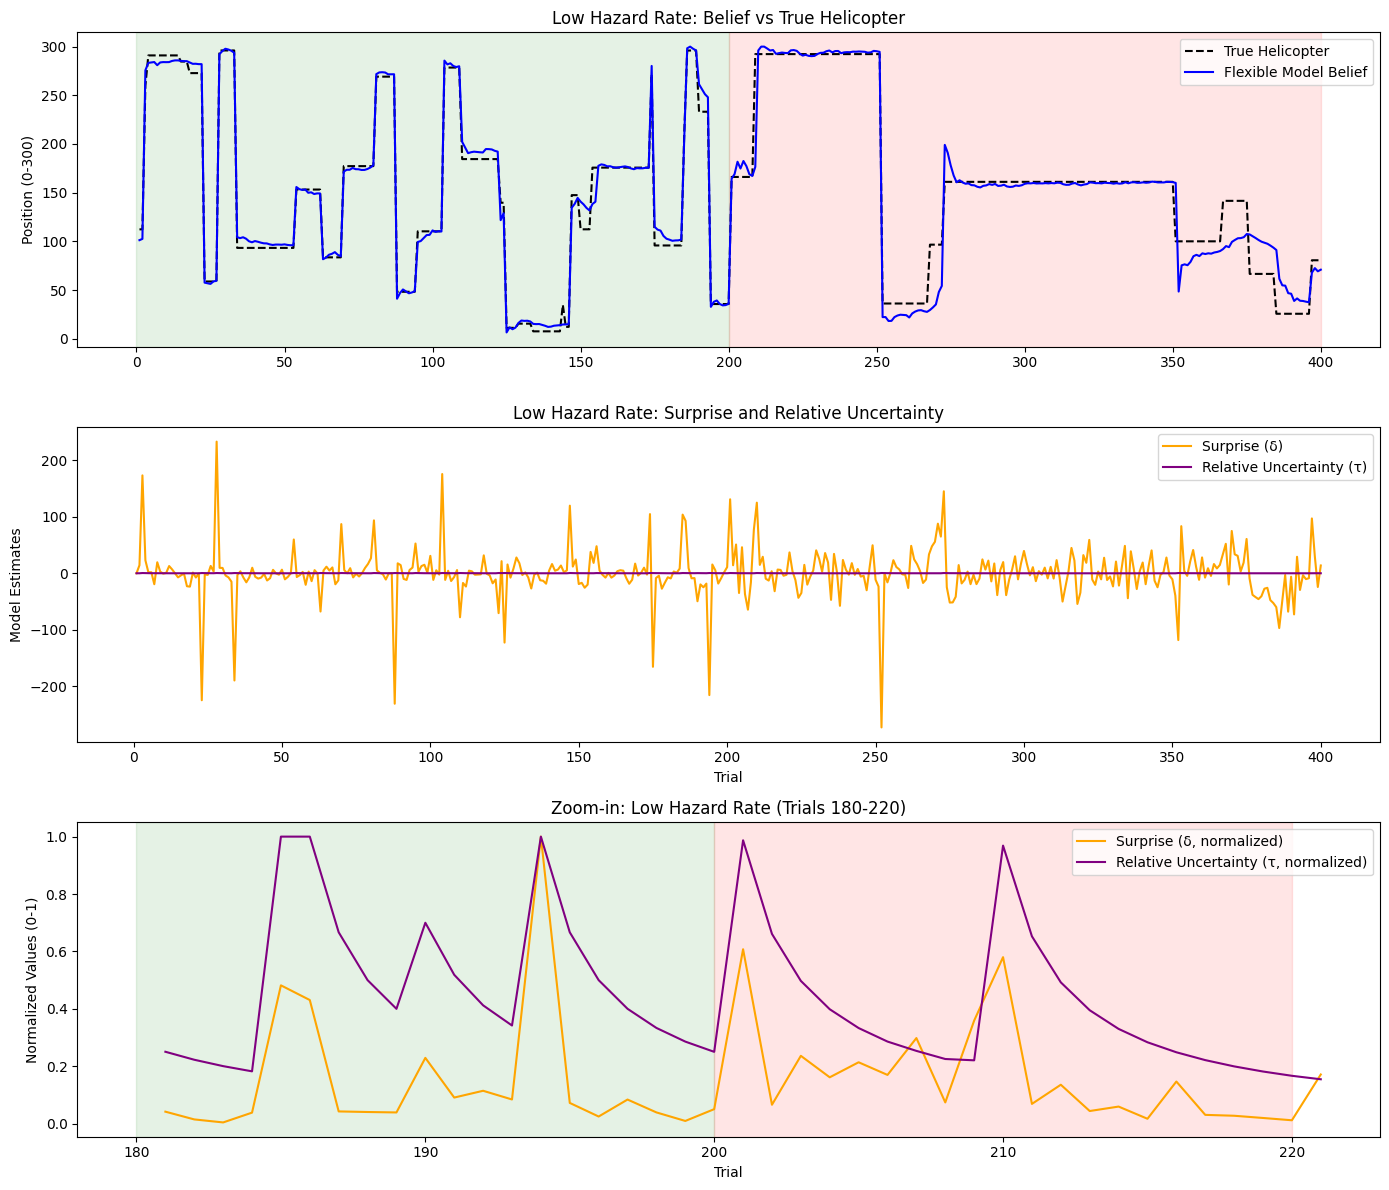

In [ ]:
plt.figure(figsize=(14,12))

# Top plot: Belief vs True Helicopter
plt.subplot(3,1,1)
plt.plot(flex_model_hazard['Trial'], flex_model_hazard['TruePosition'], 'k--', label='True Helicopter')
plt.plot(flex_model_hazard['Trial'], flex_model_hazard['Belief'], 'b-', label='Flexible Model Belief')
plt.axvspan(0, 200, color='green', alpha=0.1)
plt.axvspan(200, 400, color='red', alpha=0.1)
plt.ylabel("Position (0-300)")
plt.title("Low Hazard Rate: Belief vs True Helicopter")
plt.legend()

# Middle plot: Prediction error & relative uncertainty
plt.subplot(3,1,2)
plt.plot(flex_model_hazard['Trial'], flex_model_hazard['PredictionError'], color='orange', label='Surprise (δ)')
plt.plot(flex_model_hazard['Trial'], flex_model_hazard['RelUncertainty'], color='purple', label='Relative Uncertainty (τ)')
plt.ylabel("Model Estimates")
plt.xlabel("Trial")
plt.title("Low Hazard Rate: Surprise and Relative Uncertainty")
plt.legend()

# Bottom plot: Zoom-in
zoom_start, zoom_end = 180, 220
plt.subplot(3,1,3)
pred_zoom = np.abs(flex_model_hazard['PredictionError'][zoom_start:zoom_end+1])
pred_zoom_norm = pred_zoom / np.max(pred_zoom)
tau_zoom = flex_model_hazard['RelUncertainty'][zoom_start:zoom_end+1]
tau_zoom_norm = tau_zoom / np.max(tau_zoom)
trials_zoom = flex_model_hazard['Trial'][zoom_start:zoom_end+1]

plt.plot(trials_zoom, pred_zoom_norm, color='orange', label='Surprise (δ, normalized)')
plt.plot(trials_zoom, tau_zoom_norm, color='purple', label='Relative Uncertainty (τ, normalized)')
plt.axvspan(180, 200, color='green', alpha=0.1)
plt.axvspan(200, 220, color='red', alpha=0.1)
plt.ylabel("Normalized Values (0-1)")
plt.xlabel("Trial")
plt.title("Zoom-in: Low Hazard Rate (Trials 180-220)")
plt.legend()

plt.tight_layout()
plt.show()

# Learning Rate Trajectories Compared to the Normative Model

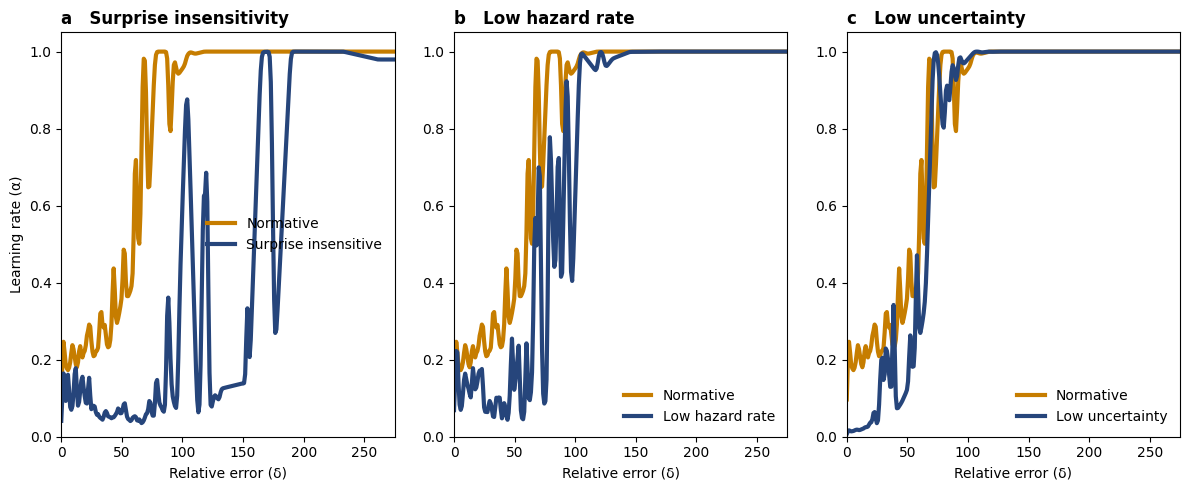

In [ ]:
all_models = [
    normative_model,
    flex_model_surprise,
    flex_model_hazard,
    flex_model_uncertainty
]

max_pe = max(np.abs(m['PredictionError']).max() for m in all_models)
delta_vals = np.linspace(0, max_pe, 300)  # covers full realistic range

# ---- 2. Helper: sort & interpolate smoothly ----
def sorted_interp(model, delta_vals, smooth_sigma=1):
    """Sorts model data by |PredictionError| before interpolation and smooths."""
    idx = np.argsort(np.abs(model['PredictionError']))
    x = np.abs(model['PredictionError'].values[idx])
    y = model['LearningRate'].values[idx]
    # Interpolate to uniform x scale
    interp_y = np.interp(delta_vals, x, y)
    # Optional smoothing for visual polish
    return gaussian_filter1d(interp_y, sigma=smooth_sigma)

# ---- 3. Compute curves ----
alpha_norm = sorted_interp(normative_model, delta_vals)
alpha_surprise = sorted_interp(flex_model_surprise, delta_vals)
alpha_hazard = sorted_interp(flex_model_hazard, delta_vals)
alpha_uncertainty = sorted_interp(flex_model_uncertainty, delta_vals)

# ---- 4. Styling ----
plt.figure(figsize=(12, 5))

colors = {
    'normative': '#c67d00',  # warm gold
    'variant': '#26457b'     # dark blue
}

# ---- (a) Surprise insensitivity ----
plt.subplot(1, 3, 1)
plt.plot(delta_vals, alpha_norm, color=colors['normative'], linewidth=3, label='Normative')
plt.plot(delta_vals, alpha_surprise, color=colors['variant'], linewidth=3, label='Surprise insensitive')
plt.title("a   Surprise insensitivity", loc='left', fontsize=12, fontweight='bold')
plt.xlabel("Relative error (δ)")
plt.ylabel("Learning rate (α)")
plt.xlim(0, max_pe)
plt.ylim(0, 1.05)
plt.legend(frameon=False)
plt.tick_params(direction='out')
plt.grid(False)

# ---- (b) Low hazard rate ----
plt.subplot(1, 3, 2)
plt.plot(delta_vals, alpha_norm, color=colors['normative'], linewidth=3, label='Normative')
plt.plot(delta_vals, alpha_hazard, color=colors['variant'], linewidth=3, label='Low hazard rate')
plt.title("b   Low hazard rate", loc='left', fontsize=12, fontweight='bold')
plt.xlabel("Relative error (δ)")
plt.xlim(0, max_pe)
plt.ylim(0, 1.05)
plt.legend(frameon=False)
plt.tick_params(direction='out')
plt.grid(False)

# ---- (c) Low uncertainty ----
plt.subplot(1, 3, 3)
plt.plot(delta_vals, alpha_norm, color=colors['normative'], linewidth=3, label='Normative')
plt.plot(delta_vals, alpha_uncertainty, color=colors['variant'], linewidth=3, label='Low uncertainty')
plt.title("c   Low uncertainty", loc='left', fontsize=12, fontweight='bold')
plt.xlabel("Relative error (δ)")
plt.xlim(0, max_pe)
plt.ylim(0, 1.05)
plt.legend(frameon=False)
plt.tick_params(direction='out')
plt.grid(False)

plt.tight_layout(w_pad=2)
plt.show()

## Your Turn: Background

Nassar et. al. 2022 recreates this model to study the all-or-nothing belief system update observed in individuals with schizophrenia.

The finding was that of pronounced reduction in moderate belief updates. They instead relied on extremes:

1. Non-updates/Perseverative responses: Completely ignoring new information (learning rate near 0).

2. Total updates: Completely adopting the new information (learning rate near 1).

# A New Environment

One slight modification the 2022 study made to the 2016 experiment, was an "odd-ball condition", which was a slight drift of the helicopter via **random walk**. This were essentially one-off outliers that didn't actually indicate a change-point occurence. Really unexpected bag locations were meant to be indicative of an odd-ball, encouraged to be ignored by participants.

In [ ]:
def generate_oddball_environment(n_trials=400, H_oddball=0.1, sigma=20, drift_rate=10, seed=555):
    """
    Generate helicopter (true) and bag (observed) positions for oddball condition:
    - Helicopter undergoes Gaussian random walk (gradual drift)
    - Occasional oddball bag drops (unrelated to helicopter position)
    - Static noise level throughout all trials
    Hazard rate H_oddball controls probability of oddball events (not changepoints)
    Range of positions: 0-300
    """
    np.random.seed(seed)  # reproducibility

    # Single static noise level for all trials
    sigma_sequence = np.full(n_trials, sigma)

    mu = np.zeros(n_trials)  # true helicopter position
    X = np.zeros(n_trials)   # observed bag drops
    is_oddball = np.zeros(n_trials, dtype=bool)  # track oddball trials

    # Initialize helicopter in center of range
    mu[0] = 150  # Start at center

    X[0] = np.random.normal(mu[0], sigma_sequence[0])

    # Generate trials
    for t in range(1, n_trials):
        # Helicopter undergoes random walk with reflecting boundaries
        drift = np.random.normal(0, drift_rate)
        proposed_position = mu[t - 1] + drift

        # Reflecting boundaries: bounce back if hitting edges
        if proposed_position < 0:
            mu[t] = -proposed_position  # Reflect off bottom
        elif proposed_position > 300:
            mu[t] = 600 - proposed_position  # Reflect off top
        else:
            mu[t] = proposed_position

        # Ensure still within bounds after reflection
        mu[t] = np.clip(mu[t], 0, 300)

        # Oddball decision: bag from random location or helicopter location?
        if np.random.rand() < H_oddball:
            # Oddball: bag from uniform distribution (anywhere on screen)
            X[t] = np.random.uniform(0, 300)
            is_oddball[t] = True
        else:
            # Normal: bag from helicopter location with noise
            X[t] = np.random.normal(mu[t], sigma_sequence[t])

    return mu, X, sigma_sequence, is_oddball

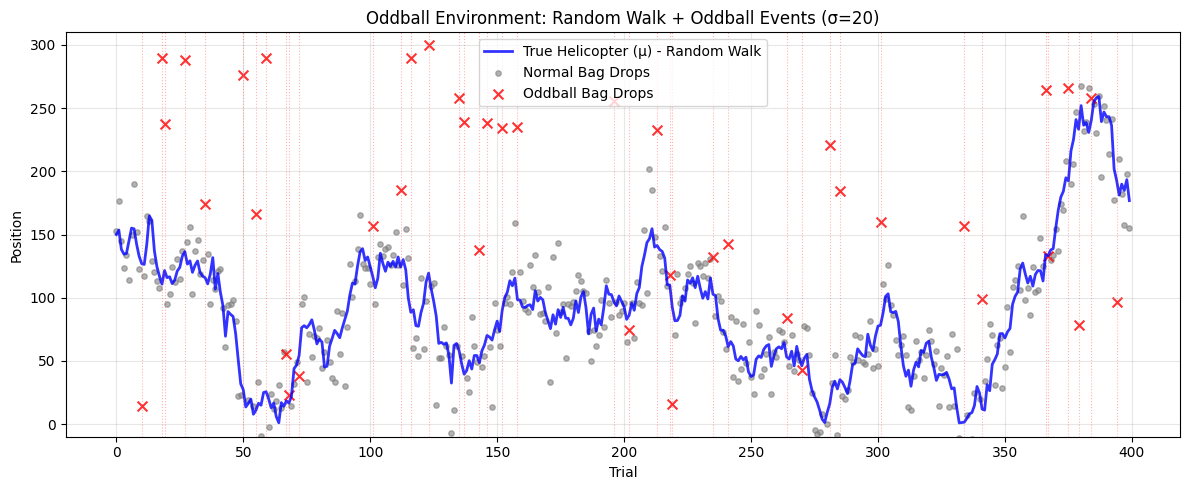

Total trials: 400
Oddball events: 41 (10.2%)
Oddball trials: [10 18 19 27 35 50 55 59 67 68]... (showing first 10)


In [ ]:
mu_oddball, X_oddball, sigma_seq_oddball, is_oddball = generate_oddball_environment()

plt.figure(figsize=(12, 5))

# Plot true helicopter position (random walk)
plt.plot(mu_oddball, label='True Helicopter (μ) - Random Walk', linewidth=2, color='blue', alpha=0.8)

# Plot normal bag drops
normal_trials = ~is_oddball
plt.scatter(np.where(normal_trials)[0], X_oddball[normal_trials],
            s=15, alpha=0.6, label='Normal Bag Drops', color='gray')

# Plot oddball bag drops in distinct color
oddball_trials = is_oddball
plt.scatter(np.where(oddball_trials)[0], X_oddball[oddball_trials],
            s=50, alpha=0.8, label='Oddball Bag Drops', color='red', marker='x')

# Add vertical dotted lines for each oddball occurrence
for t in np.where(is_oddball)[0]:
    plt.axvline(t, color='red', linestyle=':', alpha=0.3, linewidth=0.8)

plt.title('Oddball Environment: Random Walk + Oddball Events (σ=20)')
plt.xlabel('Trial')
plt.ylabel('Position')
plt.ylim(-10, 310)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Total trials: {len(X_oddball)}")
print(f"Oddball events: {np.sum(is_oddball)} ({100*np.mean(is_oddball):.1f}%)")
print(f"Oddball trials: {np.where(is_oddball)[0][:10]}... (showing first 10)")

# How would we expect our normative model to learn in this environment?

In [ ]:
# REMINDER OF VARIABLES:

# mu_oddball, X_oddball, sigma_seq_oddball, is_oddball = generate_oddball_environment()

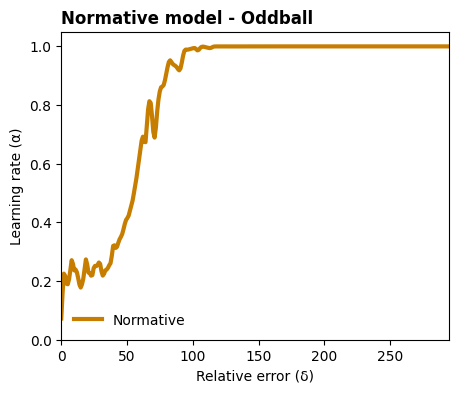

In [ ]:
norm_in_oddball = run_normative_model_df(X_oddball, sigma_seq_oddball, H=0.125)

plt.figure(figsize=(5, 4))
plt.plot(delta_vals, alpha_norm, color=colors['normative'], linewidth=3, label='Normative')
plt.title("Normative model - Oddball", loc='left', fontsize=12, fontweight='bold')
plt.xlabel("Relative error (δ)")
plt.ylabel("Learning rate (α)")
plt.xlim(0, max(delta_vals))
plt.ylim(0, 1.05)
plt.legend(frameon=False)
plt.tick_params(direction='out')
plt.grid(False)
plt.show()

# How MIGHT we expect older participants to learn in this environment, given our 2016 model?

We have to also keep in mind that this model only contains the parameters from the 2016 model, and may miss possible factors that are captured in the 2021 model.

In [ ]:
older_in_oddball = run_flexible_model(X_oddball, sigma_seq_oddball, fixed_uncertainty_scale=10, fixed_hazard_rate = 0.125)

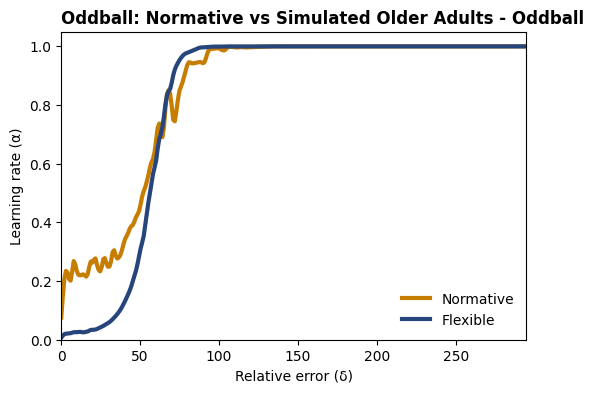

In [ ]:
# ---- 1. Prepare delta_vals ----
max_pe = max(
    np.abs(norm_in_oddball['PredictionError']).max(),
    np.abs(older_in_oddball['PredictionError']).max()
)
delta_vals = np.linspace(0, max_pe, 300)  # smooth range

# ---- 2. Helper for sorting + interpolation + smoothing ----
def sorted_interp(model, delta_vals, smooth_sigma=1):
    idx = np.argsort(np.abs(model['PredictionError']))
    x = np.abs(model['PredictionError'].values[idx])
    y = model['LearningRate'].values[idx]
    interp_y = np.interp(delta_vals, x, y)
    return gaussian_filter1d(interp_y, sigma=smooth_sigma)

# ---- 3. Compute curves ----
alpha_norm = sorted_interp(norm_in_oddball, delta_vals)
alpha_flex = sorted_interp(older_in_oddball, delta_vals)

# ---- 4. Plot ----
colors = {
    'normative': '#c67d00',  # warm gold
    'variant': '#26457b'     # dark blue
}

plt.figure(figsize=(6, 4))
plt.plot(delta_vals, alpha_norm, color=colors['normative'], linewidth=3, label='Normative')
plt.plot(delta_vals, alpha_flex, color=colors['variant'], linewidth=3, label='Flexible')
plt.title("Oddball: Normative vs Simulated Older Adults - Oddball", loc='left', fontsize=12, fontweight='bold')
plt.xlabel("Relative error (δ)")
plt.ylabel("Learning rate (α)")
plt.xlim(0, max_pe)
plt.ylim(0, 1.05)
plt.legend(frameon=False)
plt.tick_params(direction='out')
plt.grid(False)
plt.show()